In [1]:
import ta
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
class StockPredictionAndAnomalyDetection:
    def __init__(self, time_steps=60, anomaly_model='IsolationForest'):
        self.time_steps = time_steps
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.lstm_model = None
        self.anomaly_model = anomaly_model
        self.anomaly_detector = None
        self.scaled_data = None

    def mean_absolute_percentage_error(self, y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        non_zero = (y_true != 0)
        return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

    def prepare_data(self, df):
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
        df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
        df['MACD'] = ta.trend.macd(df['Close'])
        df['Bollinger_High'] = ta.volatility.bollinger_hband(df['Close'])
        df['Bollinger_Low'] = ta.volatility.bollinger_lband(df['Close'])
        df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'])
        df['Stochastic'] = ta.momentum.stoch(df['High'], df['Low'], df['Close'])
        df['OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])
        df['Volume_Change'] = df['Volume'].pct_change()
        df['Price_Change'] = df['Close'].pct_change()
        df.fillna(method='bfill', inplace=True)
        self.scaled_data = self.scaler.fit_transform(df[['Close', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'ATR', 'Stochastic', 'OBV', 'Volume_Change', 'Price_Change']])
        return df

    def create_lstm_data(self):
        X, y = [], []
        for i in range(self.time_steps, len(self.scaled_data)):
            X.append(self.scaled_data[i-self.time_steps:i])
            y.append(self.scaled_data[i, 0])  # Close price as the target
        return np.array(X), np.array(y)

    def build_lstm_model(self):
        model = Sequential([
            LSTM(units=100, return_sequences=True, input_shape=(self.time_steps, self.scaled_data.shape[1])),
            Dropout(0.2),
            LSTM(units=75, return_sequences=True),
            Dropout(0.2),
            LSTM(units=50, return_sequences=False),
            Dropout(0.2),
            Dense(units=25),
            Dense(units=1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def train_lstm_model(self, X_train, y_train, X_val, y_val):
        lstm_checkpoint = ModelCheckpoint('combinedModel_v3.keras', save_best_only=True, monitor='val_loss', mode='min')
        lstm_early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[lstm_checkpoint, lstm_early_stop])
        return history

    def train_combined_model(self, df):
        df = self.prepare_data(df)
        X, y = self.create_lstm_data()
        X_train, X_val, y_train, y_val = X[:-200], X[-200:], y[:-200], y[-200:]
        self.lstm_model = self.build_lstm_model()
        self.train_lstm_model(X_train, y_train, X_val, y_val)
        
        # Calculate MAPE for training and validation sets
        train_predictions = self.lstm_model.predict(X_train)
        val_predictions = self.lstm_model.predict(X_val)
        
        train_predictions = self.scaler.inverse_transform(np.concatenate([train_predictions, np.zeros((train_predictions.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        val_predictions = self.scaler.inverse_transform(np.concatenate([val_predictions, np.zeros((val_predictions.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        
        y_train_actual = self.scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        y_val_actual = self.scaler.inverse_transform(np.concatenate([y_val.reshape(-1, 1), np.zeros((y_val.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        
        train_mape = self.mean_absolute_percentage_error(y_train_actual, train_predictions)
        val_mape = self.mean_absolute_percentage_error(y_val_actual, val_predictions)
        
        print(f"Training MAPE: {train_mape:.2f}%")
        print(f"Validation MAPE: {val_mape:.2f}%")
        
        residuals = y_val_actual - val_predictions
        
        if self.anomaly_model == 'IsolationForest':
            self.anomaly_detector = IsolationForest(contamination=0.05, random_state=42)
        elif self.anomaly_model == 'OneClassSVM':
            self.anomaly_detector = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
        elif self.anomaly_model == 'LocalOutlierFactor':
            self.anomaly_detector = LocalOutlierFactor(novelty=True, contamination=0.05)
        else:
            raise ValueError("Unsupported anomaly detection model.")
        
        self.anomaly_detector.fit(residuals.reshape(-1, 1))

    def predict_future(self, days_to_predict):
        last_sequence = self.scaled_data[-self.time_steps:]
        future_predictions = []

        for _ in range(days_to_predict):
            next_pred = self.lstm_model.predict(last_sequence.reshape(1, self.time_steps, -1))
            future_predictions.append(next_pred[0])
            last_sequence = np.roll(last_sequence, -1, axis=0)
            last_sequence[-1] = next_pred

        future_predictions = np.array(future_predictions)
        future_predictions = self.scaler.inverse_transform(np.concatenate([future_predictions, np.zeros((future_predictions.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        return future_predictions

    def detect_anomalies(self, df, future_predictions=None):
        df = self.prepare_data(df)
        X, y = self.create_lstm_data()
        predicted_prices = self.lstm_model.predict(X)
        predicted_prices = self.scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        actual_prices = self.scaler.inverse_transform(np.concatenate([y.reshape(-1, 1), np.zeros((y.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        
        # Calculate MAPE for the entire dataset
        overall_mape = self.mean_absolute_percentage_error(actual_prices, predicted_prices)
        print(f"Overall MAPE: {overall_mape:.2f}%")
        
        residuals = actual_prices - predicted_prices
        anomalies = self.anomaly_detector.predict(residuals.reshape(-1, 1))

        if future_predictions is not None:
            future_residuals = np.zeros(len(future_predictions))
            future_anomalies = self.anomaly_detector.predict(future_residuals.reshape(-1, 1))
            return actual_prices, predicted_prices, anomalies, future_predictions, future_anomalies

        return actual_prices, predicted_prices, anomalies
    
    def visualize_predictions_and_anomalies(self, df, future_days=30):
        actual_prices, predicted_prices, anomalies, future_predictions, future_anomalies = self.detect_anomalies(df, self.predict_future(future_days))
        
        overall_mape = self.mean_absolute_percentage_error(actual_prices, predicted_prices)

        plt.figure(figsize=(16, 6))
        plt.plot(df.index[-len(predicted_prices):], actual_prices, color='blue', label='Actual Stock Price')
        plt.plot(df.index[-len(predicted_prices):], predicted_prices, color='red', label='Predicted Stock Price')
        plt.scatter(df.index[-len(predicted_prices):][anomalies == -1], actual_prices[anomalies == -1], color='green', label='Historical Anomalies')

        future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_days)
        plt.plot(future_dates, future_predictions, color='orange', label='Future Predictions')
        plt.scatter(future_dates[future_anomalies == -1], future_predictions[future_anomalies == -1], color='purple', label='Potential Future Anomalies')

        plt.title(f'Stock Price Prediction with Anomalies and Future Forecast (MAPE: {overall_mape:.2f}%)')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

        print(f"Number of historical anomalies detected: {np.sum(anomalies == -1)}")
        print(f"Percentage of historical data points marked as anomalies: {100 * np.mean(anomalies == -1):.2f}%")
        print(f"Number of potential future anomalies detected: {np.sum(future_anomalies == -1)}")
        print(f"Percentage of future predictions marked as potential anomalies: {100 * np.mean(future_anomalies == -1):.2f}%")

    def create_specific_plots(self, df, future_days=30):
        actual_prices, predicted_prices, anomalies, future_predictions, future_anomalies = self.detect_anomalies(df, self.predict_future(future_days))
        
        # Plot 1: Entire actual stock price + historical anomalies
        plt.figure(figsize=(16, 6))
        plt.plot(df.index, df['Close'], color='blue', label='Actual Stock Price')
        plt.scatter(df.index[-len(predicted_prices):][anomalies == -1], 
                    df['Close'].values[-len(predicted_prices):][anomalies == -1], 
                    color='red', label='Historical Anomalies')
        plt.title('Actual Stock Price with Historical Anomalies')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

        # Plot 2: Actual stock price + future predictions
        plt.figure(figsize=(16, 6))
        plt.plot(df.index, df['Close'], color='blue', label='Actual Stock Price')
        future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_days)
        plt.plot(future_dates, future_predictions, color='red', label='Future Predictions')
        plt.title('Actual Stock Price with Future Predictions')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

        print(f"Number of historical anomalies detected: {np.sum(anomalies == -1)}")
        print(f"Percentage of historical data points marked as anomalies: {100 * np.mean(anomalies == -1):.2f}%")        

In [3]:
ticker = 'GME'
stockPrices = yf.download(ticker, '1981-01-01', '2024-07-25')
stockPrices.columns = stockPrices.columns.str.strip()

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Train and evaluate the combined model
model = StockPredictionAndAnomalyDetection(anomaly_model='IsolationForest')
model.train_combined_model(stockPrices)

C:\Users\Loricson\AppData\Local\Temp\ipykernel_38464\4228251117.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 9.8053e-04 - val_loss: 0.0019
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 7.9732e-04 - val_loss: 0.0017
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 6.9723e-04 - val_loss: 0.0017
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 7.6361e-04 - val_loss: 0.0015
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 5.8391e-04 - val_loss: 0.0016
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 4.8472e-04 - val_loss: 0.0014
Epoch 12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

C:\Users\Loricson\AppData\Local\Temp\ipykernel_38464\4228251117.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Overall MAPE: 7.00%


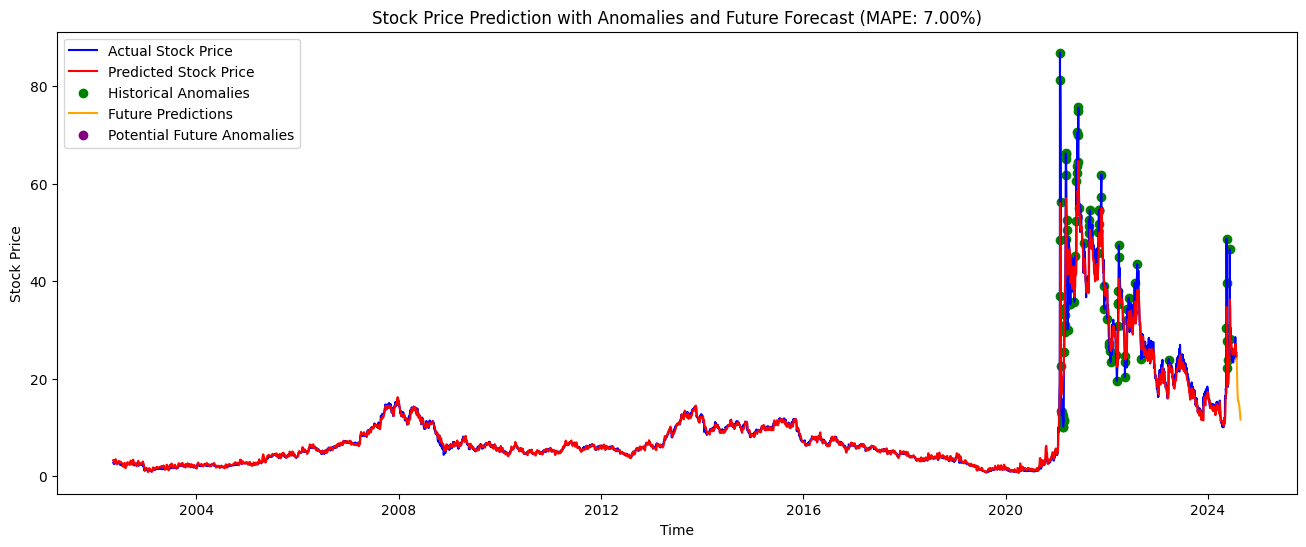

Number of historical anomalies detected: 96
Percentage of historical data points marked as anomalies: 1.72%
Number of potential future anomalies detected: 0
Percentage of future predictions marked as potential anomalies: 0.00%


In [5]:
model.visualize_predictions_and_anomalies(stockPrices, future_days=30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

C:\Users\Loricson\AppData\Local\Temp\ipykernel_38464\4228251117.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Overall MAPE: 7.00%


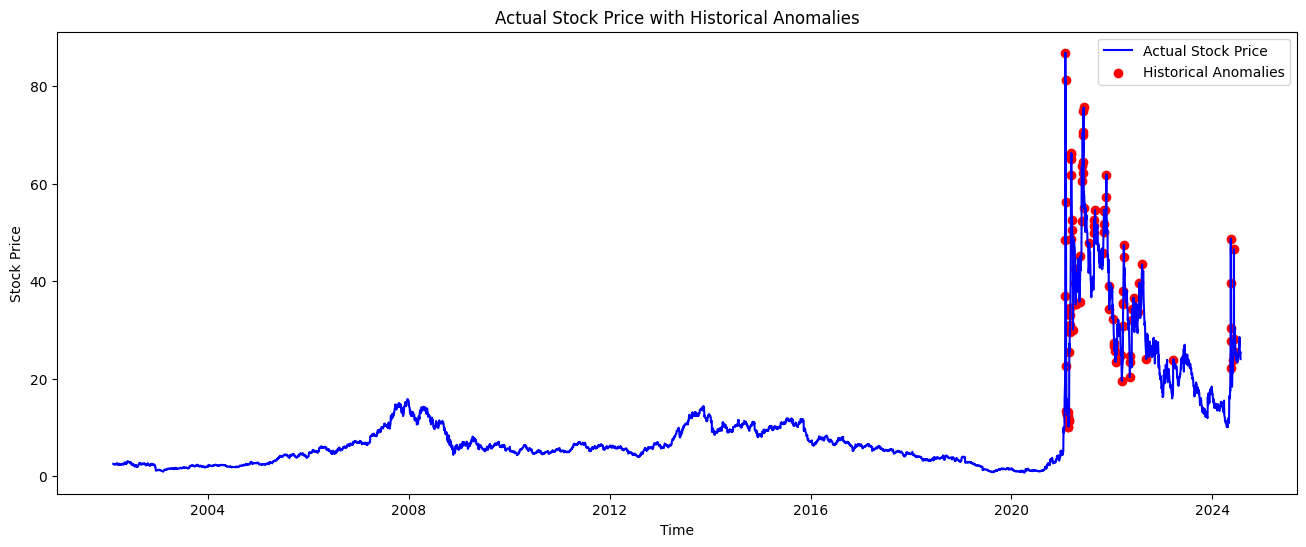

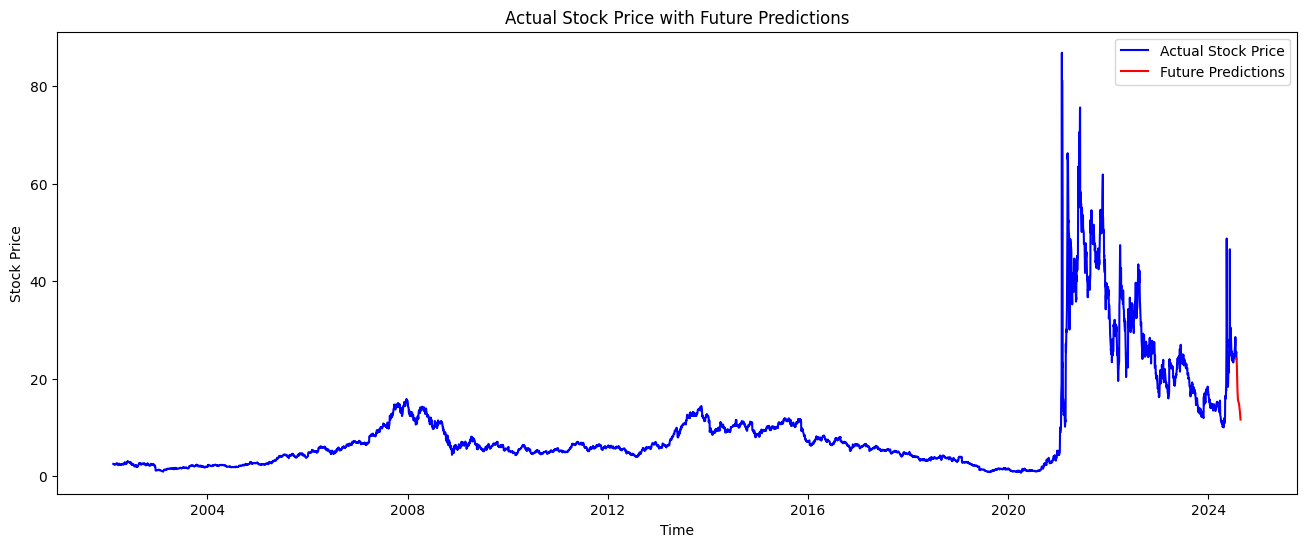

Number of historical anomalies detected: 96
Percentage of historical data points marked as anomalies: 1.72%


In [6]:
model.create_specific_plots(stockPrices, future_days=30)